# Funciones auxiliares

Definimos una serie de funciones, que nos ayudarán con el tratado de las imágenes

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def norm(im):
    """Normaliza una imagen de números reales a [0,1]"""

    return cv2.normalize(im, None, 0.0, 1.0, cv2.NORM_MINMAX)

def read_im(filename, color_flag = 1):
    """Devuelve una imagen de números reales adecuadamente leída en grises o en color.
        - filename: ruta de la imagen.
        - color_flag: indica si es en color (1) o en grises (0)."""

    try:
        im = cv2.imread(filename, color_flag)
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    except:
        print("Error: no se ha podido cargar la imagen " + filename)
        quit()

    return im.astype(np.double)

def print_im(im, title = "", show = True, tam = (10, 10)):
    """Muestra una imagen cualquiera normalizada.
        - im: imagen a mostrar.
        - show: indica si queremos mostrar la imagen inmediatamente.
        - tam = (width, height): tamaño del plot."""

    show_title = len(title) > 0

    if show:
        fig = plt.figure(figsize = tam)

    im = norm(im)  # Normalizamos a [0,1]
    plt.imshow(im, interpolation = None, cmap = 'gray')
    plt.xticks([]), plt.yticks([])

    if show:
        if show_title:
            plt.title(title)
        plt.show() 

def print_multiple_im(vim, titles = "", ncols = 2, tam = (10, 10)):
    """Muestra una sucesión de imágenes en la misma ventana, eventualmente con sus títulos.
        - vim: sucesión de imágenes a mostrar.
        - titles: o bien vacío o bien una sucesión de títulos del mismo tamaño que vim.
        - ncols: número de columnas del multiplot.
        - tam = (width, height): tamaño del multiplot."""

    show_title = len(titles) > 0

    nrows = len(vim) // ncols + (0 if len(vim) % ncols == 0 else 1)
    plt.figure(figsize = tam)

    for i in range(len(vim)):
        plt.subplot(nrows, ncols, i + 1)
        if show_title:
            plt.title(titles[i])
        print_im(vim[i], title = "", show = False)

    plt.show()

# Brain Tumor Detector DATA




IMPORTANTE: La base de datos que usamos se encuentra en [kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri), y la hemos subido convenientemente a nuestro drive colaborativo para poder cargarla.

Con la siguiente función vamos a leer las imágenes de las carpetas donde tenemos los datos y les haremos un redimensionado a (224,224) por temas de uso de RAM en googleColab

In [ ]:
import cv2 
import os

from google.colab import drive
drive.mount('/content/drive')

def load_images_from_folder(folder, len):
    images = []
    i=1
    for filename in os.listdir(folder):
        img = read_im(os.path.join(folder,filename),1)
        img = cv2.resize(img,(224,224))
        if img is not None:
            images.append(img)
        if i == len:
          break
        i += 1
    return images

PATH="/content/drive/MyDrive/Colab Notebooks/Proyecto VC/"

Mounted at /content/drive


Cargamos los datos, vamos a cargar toda la base de datos de no_tumor que son 500 instancias y cargaremos 500/3 instancias de cada tipo de tumor.

In [ ]:
data=load_images_from_folder(PATH + "images/Training/no_tumor",395)
data= data + load_images_from_folder(PATH + "images/Testing/no_tumor",105)
data= data + load_images_from_folder(PATH + "images/Testing/glioma_tumor",41)
data= data + load_images_from_folder(PATH + "images/Training/glioma_tumor",125)
data= data + load_images_from_folder(PATH + "images/Testing/meningioma_tumor",42)
data= data + load_images_from_folder(PATH + "images/Training/meningioma_tumor",125)
data= data + load_images_from_folder(PATH + "images/Testing/pituitary_tumor",42)
data= data + load_images_from_folder(PATH + "images/Training/pituitary_tumor",125)

In [ ]:
data=np.array(data)
data.shape

(1000, 224, 224, 3)

Ahora creo las etiquetas: (1,0) para imágenes con tumor y (0,1) para imágenes sin tumor

In [ ]:
data_labels=[[0,1] for i in range(0,500)]+[[1,0] for i in range(0,500)]

In [ ]:
data_labels=np.array(data_labels)
data_labels.shape

(1000, 2)

finalmente los conjuntos con un 25% para test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.25)


In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((750, 224, 224, 3), (250, 224, 224, 3), (750, 2), (250, 2))

# DenseNet121 preentrenado

Primero, hemos probado a usar densenet121 preentrenado con ImagenNet más una capa Dense de 2 para amoldarlo a nuestro problema binario.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=Adam()
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3), pooling='avg')

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))





250/250 [==============================] - 2s 10ms/step


Epoch 1/50
22/22 [==============================] - 0s 9ms/step - loss: 0.8311 - accuracy: 0.5789 - val_loss: 0.6054 - val_accuracy: 0.7733
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.7846 - val_loss: 0.5075 - val_accuracy: 0.8133
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.4553 - accuracy: 0.8159 - val_loss: 0.4572 - val_accuracy: 0.8533
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8507 - val_loss: 0.4230 - val_accuracy: 0.8667
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.8537 - val_loss: 0.4080 - val_accuracy: 0.8667
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3402 - accuracy: 0.8855 - val_loss: 0.4078 - val_accuracy: 0.8533
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.3375 - accuracy: 0.8756 - val_loss: 0.3797 - val_accuracy: 0.8933
Epoch 8/50
22/22 [==

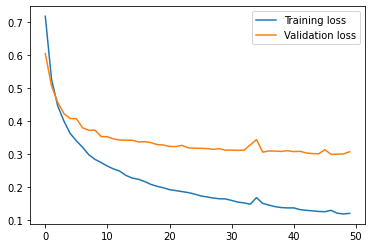

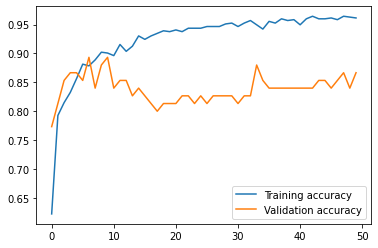

In [ ]:
#clasificamos con la salida en otra red

basemodel_simple = Sequential()
basemodel_simple.add(Dense(2, activation = 'softmax'))

basemodel_simple.compile(loss=keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

results=basemodel_simple.fit(carac_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_split=0.1)


# evaluamos la red en el conjunto de test
score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(results)

# DenseNet preentrenado Mejorado

En este apartado hemos tratado de mejorar el modelo anterior mediante una serie de capas convolucionales.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))

250/250 [==============================] - 2s 10ms/step


Epoch 1/50
22/22 [==============================] - 2s 41ms/step - loss: 0.4919 - accuracy: 0.7586 - val_loss: 0.8996 - val_accuracy: 0.5867
Epoch 2/50
22/22 [==============================] - 1s 35ms/step - loss: 0.2119 - accuracy: 0.9410 - val_loss: 1.6240 - val_accuracy: 0.5200
Epoch 3/50
22/22 [==============================] - 1s 34ms/step - loss: 0.1515 - accuracy: 0.9384 - val_loss: 0.9864 - val_accuracy: 0.6667
Epoch 4/50
22/22 [==============================] - 1s 35ms/step - loss: 0.0769 - accuracy: 0.9683 - val_loss: 0.3301 - val_accuracy: 0.9067
Epoch 5/50
22/22 [==============================] - 1s 35ms/step - loss: 0.1039 - accuracy: 0.9622 - val_loss: 0.2612 - val_accuracy: 0.9067
Epoch 6/50
22/22 [==============================] - 1s 35ms/step - loss: 0.0678 - accuracy: 0.9783 - val_loss: 0.3336 - val_accuracy: 0.9200
Epoch 7/50
22/22 [==============================] - 1s 35ms/step - loss: 0.0632 - accuracy: 0.9856 - val_loss: 0.2618 - val_accuracy: 0.8800
Epoch 8/50
22

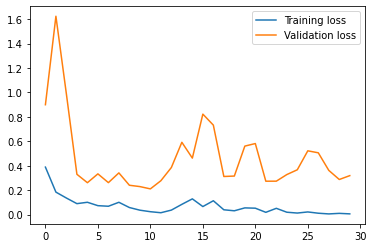

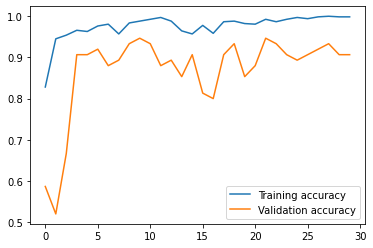

In [ ]:
#clasificamos con la salida en otra red

basemodel_simple = Sequential()
basemodel_simple.add(Conv2D(2048,padding='same', kernel_size=(3, 3)))
basemodel_simple.add(BatchNormalization())
basemodel_simple.add(Activation('relu'))
basemodel_simple.add(Dropout(0.5))
basemodel_simple.add(GlobalAveragePooling2D())
basemodel_simple.add(Dense(200, activation = 'relu'))
basemodel_simple.add(Dropout(0.5))
basemodel_simple.add(Dense(2, activation = 'softmax'))

early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_accuracy",
                                       patience = 20,
                                       restore_best_weights = True)
opt=keras.optimizers.SGD(lr = 0.01, decay = 1e-6,
                momentum = 0.9, nesterov = True)
basemodel_simple.compile(loss=keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

results=basemodel_simple.fit(carac_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_split=0.1,callbacks=[early_stopping_loss,early_stopping_val])


# evaluamos la red en el conjunto de test
score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(results)

# DenseNet121 Mejorado FineTunning Acc





En este apartado hemos reentrenado la red con las capas añadidas tras mejorar el modelo usando la métrica accuracy.

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.1)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

output = Conv2D(2048,padding='same', kernel_size=(3, 3)) (base_model.output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = GlobalAveragePooling2D()(output)
output = Dense(200, activation = 'relu')(output)
output = Dropout(0.5)(output)
output = Dense(2, activation = 'softmax')(output)

early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_accuracy",
                                       patience = 20,
                                       restore_best_weights = True)

base_model_FT = Model(inputs = base_model.input, outputs = output)

# Compilación y entrenamiento del modelo.

base_model_FT.compile(loss=keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

hist = base_model_FT.fit(datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'training'),
                    steps_per_epoch= len(X_train)*0.9/16,epochs = 25,
                    validation_data= datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'validation'),
                    validation_steps= len(X_train)*0.1/16)





Epoch 1/25
42/42 [==============================] - 19s 253ms/step - loss: 0.6094 - accuracy: 0.6491 - val_loss: 0.5282 - val_accuracy: 0.7067
Epoch 2/25
42/42 [==============================] - 9s 221ms/step - loss: 0.2268 - accuracy: 0.9227 - val_loss: 0.4883 - val_accuracy: 0.7733
Epoch 3/25
42/42 [==============================] - 9s 223ms/step - loss: 0.0982 - accuracy: 0.9777 - val_loss: 0.1976 - val_accuracy: 0.9333
Epoch 4/25
42/42 [==============================] - 9s 221ms/step - loss: 0.0637 - accuracy: 0.9862 - val_loss: 0.1657 - val_accuracy: 0.9467
Epoch 5/25
42/42 [==============================] - 9s 219ms/step - loss: 0.0613 - accuracy: 0.9819 - val_loss: 0.0831 - val_accuracy: 0.9467
Epoch 6/25
42/42 [==============================] - 9s 219ms/step - loss: 0.0268 - accuracy: 0.9952 - val_loss: 0.3001 - val_accuracy: 0.9200
Epoch 7/25
42/42 [==============================] - 9s 218ms/step - loss: 0.0553 - accuracy: 0.9822 - val_loss: 0.1275 - val_accuracy: 0.9467
Epoch

Test loss: 0.07814309746026993
Test binary_accuracy: 0.984000027179718


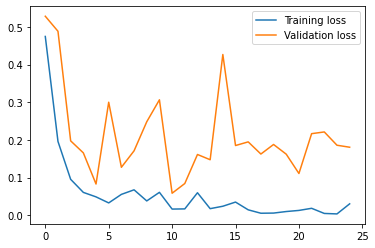

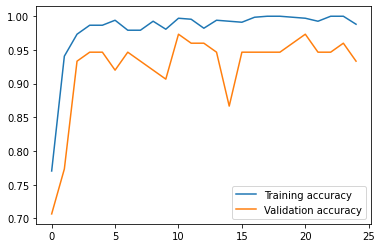

In [ ]:
# evaluamos la red en el conjunto de test
score = base_model_FT.evaluate(datagen_test.flow(X_test,
                                                  y_test,
                                                  batch_size = 1,
                                                  shuffle = False),
                                      verbose = 0,
                                      steps = len(X_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

mostrarEvolucion(hist)

# DenseNet121 Mejorado FineTunning F1

En este apartado hemos realizado lo mismo que en el anterior pero con la métrica F1

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['f1_m']
  val_acc = hist.history['val_f1_m']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training F1 score', 'Validation F1 score'])
  plt.show()

#A continuación definicmos la métrica F1 y las métricas usadas para su cálculo.

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt=SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.1)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3))

output = Conv2D(2048,padding='same', kernel_size=(3, 3)) (base_model.output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = GlobalAveragePooling2D()(output)
output = Dense(200, activation = 'relu')(output)
output = Dropout(0.5)(output)
output = Dense(2, activation = 'softmax')(output)

early_stopping_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 20,
                                        restore_best_weights = True)
early_stopping_val = EarlyStopping(monitor = "val_f1_m",
                                       patience = 20,
                                       restore_best_weights = True)

base_model_FT = Model(inputs = base_model.input, outputs = output)

# Compilación y entrenamiento del modelo.

base_model_FT.compile(loss=keras.losses.binary_crossentropy, optimizer=opt, metrics=[f1_m])

hist = base_model_FT.fit(datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'training'),
                    steps_per_epoch= len(X_train)*0.9/16,epochs = 25,
                    validation_data= datagen_train.flow(X_train, y_train,batch_size= 16, subset = 'validation'),
                    validation_steps= len(X_train)*0.1/16)





Epoch 1/25
42/42 [==============================] - 20s 255ms/step - loss: 0.6254 - f1_m: 0.6509 - val_loss: 0.4442 - val_f1_m: 0.7636
Epoch 2/25
42/42 [==============================] - 9s 222ms/step - loss: 0.2035 - f1_m: 0.9346 - val_loss: 0.3662 - val_f1_m: 0.7648
Epoch 3/25
42/42 [==============================] - 9s 222ms/step - loss: 0.1061 - f1_m: 0.9570 - val_loss: 0.2505 - val_f1_m: 0.9125
Epoch 4/25
42/42 [==============================] - 9s 221ms/step - loss: 0.0777 - f1_m: 0.9779 - val_loss: 0.4819 - val_f1_m: 0.8250
Epoch 5/25
42/42 [==============================] - 9s 219ms/step - loss: 0.0601 - f1_m: 0.9852 - val_loss: 0.1547 - val_f1_m: 0.9750
Epoch 6/25
42/42 [==============================] - 9s 219ms/step - loss: 0.0360 - f1_m: 0.9945 - val_loss: 0.1001 - val_f1_m: 0.9625
Epoch 7/25
42/42 [==============================] - 9s 218ms/step - loss: 0.0272 - f1_m: 0.9812 - val_loss: 0.1490 - val_f1_m: 0.9500
Epoch 8/25
42/42 [==============================] - 9s 218ms/

Test loss: 0.10091348737478256
Test F1 score: 0.9639999270439148


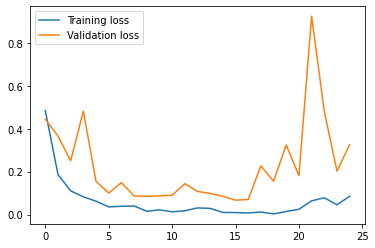

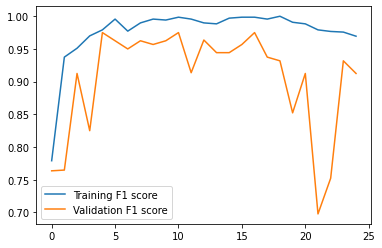

In [ ]:
# evaluamos la red en el conjunto de test
score = base_model_FT.evaluate(datagen_test.flow(X_test,
                                                  y_test,
                                                  batch_size = 1,
                                                  shuffle = False),
                                      verbose = 0,
                                      steps = len(X_test))
print('Test loss:', score[0])
print('Test F1 score:', score[1])

mostrarEvolucion(hist)

# Predicción

vamos a coger una imagen del conjunto de test para probar la predicción

In [ ]:
y_test[214]

array([1, 0])

In [ ]:
X_pred=np.array([X_test[214]])

carac_pred = base_model_FT.predict(datagen_test.flow(X_pred,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_pred))

1/1 [==============================] - 0s 43ms/step


In [ ]:
carac_pred

array([[1.0000000e+00, 6.7024977e-09]], dtype=float32)

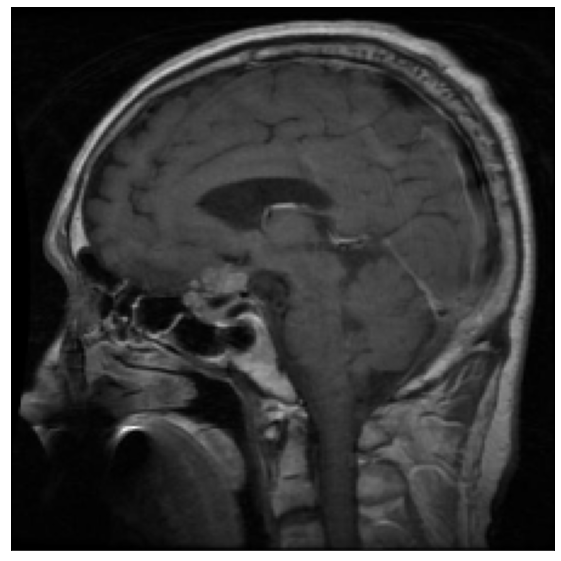

In [ ]:
print_im(X_pred[0])